In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
from shapely.geometry import multipolygon
import shapely.wkt
import geopandas


# Begin Models

In [3]:
modl = pd.read_csv('insight/Cross_val_model_set_with_income_feb5.csv')
modl.shape

(604182, 21)

In [4]:
#modl = t
#Create dummy variables
dummy_cityowned = pd.get_dummies(modl['CityOwned'],prefix='city')
dummy_zip = pd.get_dummies(modl['zip'], prefix='zip')
dummy_taxclass = pd.get_dummies(modl['taxclass'],prefix='tax')

dummy_taxclass.drop('tax_1',inplace=True,axis=1)
dummy_cityowned.drop('city_No', inplace=True, axis=1)
dummy_zip.drop('zip_10002', inplace=True, axis=1)
all_dummy = pd.concat([dummy_taxclass,dummy_cityowned, dummy_zip], axis=1)
modl_dummies = pd.concat([modl, all_dummy], axis=1)


In [6]:
from sklearn.model_selection import train_test_split

modl_train, modl_test = train_test_split(modl_dummies, test_size=0.2)
dummy_names = list(all_dummy.columns)
tax_names = list(dummy_taxclass.columns)
zip_names = list(dummy_zip.columns)
city_names = list(dummy_cityowned.columns)
#features = ['Construction Year','fullval','bldfront','blddepth', 'GROUNDELEV','Lead_Index_tenth'] + tax_names + city_names
#features = ['Construction Year','Lead_Index_tenth','Lead_Index_quarter','bldfront','blddepth', 'GROUNDELEV'] +city_names + tax_names
features = ['Construction Year', 'Lead_Index_quarter','bldfront','blddepth','GROUNDELEV', 'Median_Income','nn_diff'] + city_names+tax_names



X_train = modl_train[features]
Y_train = modl_train['Pipe Material']
X_test = modl_test[features]
Y_test = modl_test['Pipe Material']


# Logistic Regression with 10-fold cross evaluation

In [10]:
from sklearn.model_selection import KFold


X_train = modl_train[features]
Y_train = modl_train['Pipe Material']
X_test = modl_test[features]
Y_test = modl_test['Pipe Material']

#kf = KFold(n_splits=2) # Define the split - into 2 folds 
#kf.get_n_splits(modl_train[features+['Pipe Material']]) # returns the number of splitting iterations in the cross-validator
#print(kf) 

#for train_index, test_index in kf.split(X_train):
    #print(“TRAIN:”, train_index, “TEST:”, test_index)
#    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
#    y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
logreg = LogisticRegression(class_weight='balanced')
#logreg.fit(X_train,Y_train)
scores = cross_validate(logreg, X_train, Y_train, cv=10, scoring = ('precision','recall','f1','roc_auc'))
print(scores)
#grid search, random search cv

#rf=RandomForestClassifier(n_estimators =35, class_weight="balanced")
#rf_output = cross_validate(rf, X_train, Y_train, cv=5, scoring = 'accuracy', return_estimator =True)

{'fit_time': array([10.3960464 ,  8.74499202,  8.15732598,  9.9722681 , 10.67488217,
       12.14204288, 10.39204526,  9.88833332, 10.54295683,  9.84535861]), 'score_time': array([0.12492967, 0.19688416, 0.10494161, 0.11193419, 0.14991379,
       0.13892245, 0.13792109, 0.11293578, 0.1289351 , 0.11793494]), 'test_precision': array([0.39639367, 0.37000136, 0.36333744, 0.36639903, 0.37087642,
       0.39509259, 0.37292017, 0.3679827 , 0.36994166, 0.37124744]), 'train_precision': array([0.39750556, 0.36476553, 0.36342619, 0.37101069, 0.37177231,
       0.39028862, 0.37341078, 0.36690724, 0.3723751 , 0.37392333]), 'test_recall': array([0.84621065, 0.75076156, 0.7344226 , 0.72454537, 0.73165328,
       0.78777809, 0.73661374, 0.73827548, 0.73172083, 0.73522895]), 'train_recall': array([0.845712  , 0.74010442, 0.74010442, 0.73452453, 0.7344117 ,
       0.78602566, 0.73325538, 0.73939935, 0.73464008, 0.73292715]), 'test_f1': array([0.53988633, 0.49570305, 0.48615949, 0.48668424, 0.49223699,
 

Accuracy of logistic regression classifier on test set: 0.65
[[58930 34650]
 [ 7058 20199]]
             precision    recall  f1-score   support

          0       0.89      0.63      0.74     93580
          1       0.37      0.74      0.49     27257

avg / total       0.77      0.65      0.68    120837

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.758


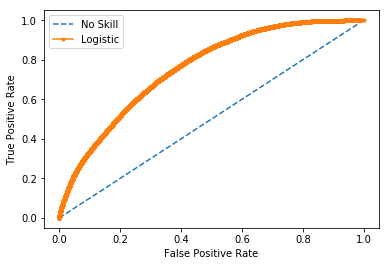

In [11]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression(random_state=0, class_weight='balanced')
#logreg.fit(modl_train[features], modl_train['Pipe Material'])

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

logreg.fit(X_train,Y_train)
## Logistic Regression
y_pred_log = logreg.predict(modl_test[features])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(modl_test[features], modl_test['Pipe Material'])))


cm = confusion_matrix(modl_test['Pipe Material'], y_pred_log)
print(cm)
print(classification_report(modl_test['Pipe Material'],y_pred_log))


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

#no skill prob
ns_probs = [0 for _ in range(len(modl_test['Pipe Material']))]
lr_probs = logreg.predict_proba(modl_test[features])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(modl_test['Pipe Material'], ns_probs)
lr_auc = roc_auc_score(modl_test['Pipe Material'], lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(modl_test['Pipe Material'], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(modl_test['Pipe Material'], lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Random Forest 10-fold

In [12]:
##### CROSS VAL RF
from sklearn.model_selection import KFold


X_train = modl_train[features]
Y_train = modl_train['Pipe Material']
X_test = modl_test[features]
Y_test = modl_test['Pipe Material']

#kf = KFold(n_splits=2) # Define the split - into 2 folds 
#kf.get_n_splits(modl_train[features+['Pipe Material']]) # returns the number of splitting iterations in the cross-validator
#print(kf) 

#for train_index, test_index in kf.split(X_train):
    #print(“TRAIN:”, train_index, “TEST:”, test_index)
#    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
#    y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#logreg = LogisticRegression(class_weight='balanced')
#logreg.fit(X_train,Y_train)
rf=RandomForestClassifier(n_estimators =35, class_weight="balanced")
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring = ('precision','recall','f1','roc_auc'))
print(scores)
#grid search, random search cv

#rf=RandomForestClassifier(n_estimators =35, class_weight="balanced")
#rf_output = cross_validate(rf, X_train, Y_train, cv=5, scoring = 'accuracy', return_estimator =True)

{'fit_time': array([ 72.95705414,  71.52701735,  71.89624023,  71.58199215,
        72.68559527,  73.02016163, 114.60938907,  72.00537801,
        74.62687469,  72.10578322]), 'score_time': array([4.44650817, 4.19160533, 4.17159104, 4.22757673, 4.21358752,
       4.23459315, 5.00919247, 4.02869201, 4.36826515, 4.45649242]), 'test_precision': array([0.63965694, 0.64269021, 0.64707419, 0.64189539, 0.63479145,
       0.65189542, 0.64389047, 0.65237286, 0.64377122, 0.64527814]), 'train_precision': array([0.99939384, 0.9994244 , 0.9993319 , 0.99932161, 0.99919838,
       0.99938329, 0.9994245 , 0.99915751, 0.99933188, 0.99932183]), 'test_recall': array([0.46127573, 0.45693714, 0.45730638, 0.45767562, 0.46081418,
       0.46035263, 0.46021049, 0.46067208, 0.45513294, 0.46048744]), 'train_recall': array([0.99776394, 0.99733314, 0.99726134, 0.99723057, 0.99725108,
       0.99730237, 0.99750754, 0.99748702, 0.99722034, 0.99754857]), 'test_f1': array([0.53601502, 0.53412463, 0.5358862 , 0.534353

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.865


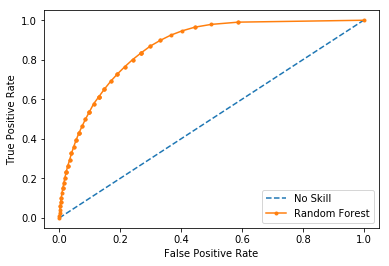

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
rf.fit(X_train,Y_train)
#no skill prob
ns_probs = [0 for _ in range(len(modl_test['Pipe Material']))]
rf_probs = rf.predict_proba(modl_test[features])
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(modl_test['Pipe Material'], ns_probs_rf)
rf_auc = roc_auc_score(modl_test['Pipe Material'], rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(modl_test['Pipe Material'], ns_probs_rf)
rf_fpr, rf_tpr, _ = roc_curve(modl_test['Pipe Material'], rf_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Hyperparameter tuning for RF model with 5-fold cross evaluation

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
weight = ['balanced']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': weight}
print(random_grid)

{'n_estimators': [100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': ['balanced']}


In [ ]:
%%time
X_train = modl_train[features]
Y_train = modl_train['Pipe Material']
X_test = modl_test[features]
Y_test = modl_test['Pipe Material']
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# Fit the random  search model
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [18]:
rf_random.best_params_

  
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#logreg = LogisticRegression(class_weight='balanced')
#logreg.fit(X_train,Y_train)
rf=RandomForestClassifier(n_estimators =150, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=None, class_weight=balanced, bootstrap=True)

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'class_weight': 'balanced',
 'bootstrap': True}

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#rf_best = rf_random.best_estimator_
rf_best=RandomForestClassifier(n_estimators =150, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=None, class_weight='balanced', bootstrap=True)
rf_best.fit(X_train,Y_train)
X_test = modl_test[features]
Y_test = modl_test['Pipe Material']

y_pred_best = rf_best.predict(X_test)

print('Accuracy of best RF classifier on test set: {:.2f}'.format(rf_best.score(X_test, Y_test)))


cm_best = confusion_matrix(Y_test, y_pred_best)
print(cm_best)
print(classification_report(Y_test,y_pred_best))


Accuracy of best RF classifier on test set: 0.82
[[84469  9029]
 [12251 15088]]
             precision    recall  f1-score   support

          0       0.87      0.90      0.89     93498
          1       0.63      0.55      0.59     27339

avg / total       0.82      0.82      0.82    120837



Accuracy of base RF classifier on test set: 0.81
[[87121  6377]
 [16070 11269]]
             precision    recall  f1-score   support

          0       0.84      0.93      0.89     93498
          1       0.64      0.41      0.50     27339

avg / total       0.80      0.81      0.80    120837

No Skill: ROC AUC=0.500
Random Forest (Base Model): ROC AUC=0.841
Random Forest (Best Model): ROC AUC=0.873


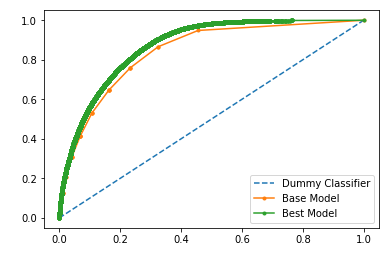

<Figure size 1080x1080 with 0 Axes>

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#logreg.fit(X_train,Y_train)
## Logistic Regression
#y_pred_log = logreg.predict(modl_test[features])

X_test = modl_test[features]
Y_test = modl_test['Pipe Material']

rf_base=RandomForestClassifier(n_estimators =10, class_weight='balanced')

rf_base.fit(X_train,Y_train)
y_pred_base = rf_base.predict(X_test)

print('Accuracy of base RF classifier on test set: {:.2f}'.format(rf_base.score(X_test, Y_test)))


cm_base = confusion_matrix(Y_test, y_pred_base)
print(cm_base)
print(classification_report(Y_test,y_pred_base))


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot




#no skill prob
ns_probs = [0 for _ in range(len(modl_test['Pipe Material']))]
rf_base_probs = rf_base.predict_proba(X_test)
rf_best_probs = rf_best.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_base_probs = rf_base_probs[:, 1]
rf_best_probs = rf_best_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
rf_base_auc = roc_auc_score(Y_test, rf_base_probs)
rf_best_auc = roc_auc_score(Y_test, rf_best_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest (Base Model): ROC AUC=%.3f' % (rf_base_auc))
print('Random Forest (Best Model): ROC AUC=%.3f' % (rf_best_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
rf_base_fpr, rf_base_tpr, _ = roc_curve(Y_test, rf_base_probs)
rf_best_fpr, rf_best_tpr, _ = roc_curve(Y_test, rf_best_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifier')
pyplot.plot(rf_base_fpr, rf_base_tpr, marker='.', label='Base Model')
pyplot.plot(rf_best_fpr, rf_best_tpr, marker='.', label='Best Model')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.figure(figsize =(15,15))
# show the plot
pyplot.show()


In [36]:
modl.corr()


,Unnamed: 0,Pipe Material,Median_Income,BBL,zip,Construction Year,GROUNDELEV,fullval,avland,avtot,HEIGHTROOF,blddepth,bldfront,taxclass,Lead_Index_halfkm,Lead_Index_quarter,Lead_Index_tenth,nn_diff
Unnamed: 0,1.000000,-0.057391,0.355444,0.937098,0.158372,0.349379,-0.021958,-0.089534,-0.056053,-0.073963,-0.315602,-0.210443,-0.084081,-0.252250,-0.275404,-0.209918,-0.199429,-0.255128
Pipe Material,-0.057391,1.000000,-0.065515,-0.048827,0.066530,-0.334538,0.028638,-0.022349,-0.018922,-0.023200,-0.040369,-0.041741,-0.067659,-0.029014,0.228367,0.287654,0.343504,0.196542
Median_Income,0.355444,-0.065515,1.000000,0.256787,-0.198182,0.128355,0.044162,0.086223,0.069025,0.072673,0.087452,-0.056457,0.000881,-0.035514,-0.240477,-0.209131,-0.203330,-0.188227
BBL,0.937098,-0.048827,0.256787,1.000000,0.246913,0.320863,0.038340,-0.115225,-0.080251,-0.101409,-0.360301,-0.210393,-0.096778,-0.255767,-0.244966,-0.182489,-0.167935,-0.231997
zip,0.158372,0.066530,-0.198182,0.246913,1.000000,-0.151089,-0.169762,-0.081109,-0.067532,-0.081508,-0.265153,-0.091727,-0.090850,-0.127594,0.315198,0.255056,0.191840,0.109020
Construction Year,0.349379,-0.334538,0.128355,0.320863,-0.151089,1.000000,-0.038194,0.005531,0.013742,0.019782,-0.053073,-0.003138,0.058019,-0.041341,-0.300340,-0.330633,-0.364796,-0.296338
GROUNDELEV,-0.021958,0.028638,0.044162,0.038340,-0.169762,-0.038194,1.000000,-0.005303,-0.007325,-0.008173,0.014028,-0.020342,0.023657,-0.043168,0.036765,0.036442,0.045127,-0.093640
fullval,-0.089534,-0.022349,0.086223,-0.115225,-0.081109,0.005531,-0.005303,1.000000,0.810658,0.995325,0.503765,0.210337,0.231207,0.134938,-0.002961,-0.006488,-0.011659,0.006793
avland,-0.056053,-0.018922,0.069025,-0.080251,-0.067532,0.013742,-0.007325,0.810658,1.000000,0.814138,0.386045,0.163440,0.184982,0.133845,-0.004312,-0.007479,-0.014431,-0.001416
avtot,-0.073963,-0.023200,0.072673,-0.101409,-0.081508,0.019782,-0.008173,0.995325,0.814138,1.000000,0.498924,0.214372,0.240791,0.154662,-0.002212,-0.005728,-0.011868,0.003001


# Naive Bayes

Accuracy of Gaussian NB classifier on test set: 0.64
[[53515 39983]
 [ 3447 23892]]
             precision    recall  f1-score   support

          0       0.94      0.57      0.71     93498
          1       0.37      0.87      0.52     27339

avg / total       0.81      0.64      0.67    120837

Accuracy: 0.6405902165727385
No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.757


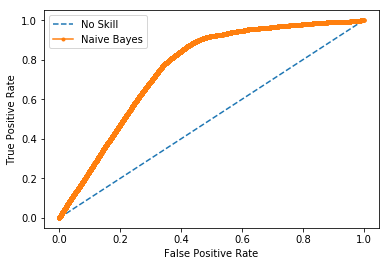

In [50]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,Y_train)
predictions_gnb = gnb.predict(X_test)

print('Accuracy of Gaussian NB classifier on test set: {:.2f}'.format(gnb.score(modl_test[features], modl_test['Pipe Material'])))

confusion_matgnb = confusion_matrix(Y_test,predictions_gnb.tolist())
print(confusion_matgnb)

print(classification_report(Y_test,predictions_gnb))
print('Accuracy:', accuracy_score(Y_test,predictions_gnb))

ns_probs = [0 for _ in range(len(Y_test))]
nb_probs = gnb.predict_proba(X_test)
# keep probabilities for the positive outcome only
nb_probs = nb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
nb_auc = roc_auc_score(Y_test, nb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(Y_test, nb_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [51]:
gnb.get_params()

{'priors': None}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
weight = ['balanced']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': weight}
print(random_grid)

In [ ]:
%%time
X_train = modl_train[features]
Y_train = modl_train['Pipe Material']
X_test = modl_test[features]
Y_test = modl_test['Pipe Material']
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# Fit the random  search model
rf_random.fit(X_train, Y_train)